Problem: High LEGO prices vs. competitors/economy. Insight/Support: +84% premium (median calc); inelastic demand (corr -0.12). Solution: Raise 8-12%.

LEGO Median: £18.92, Competitors: £10.48, Premium: +81%


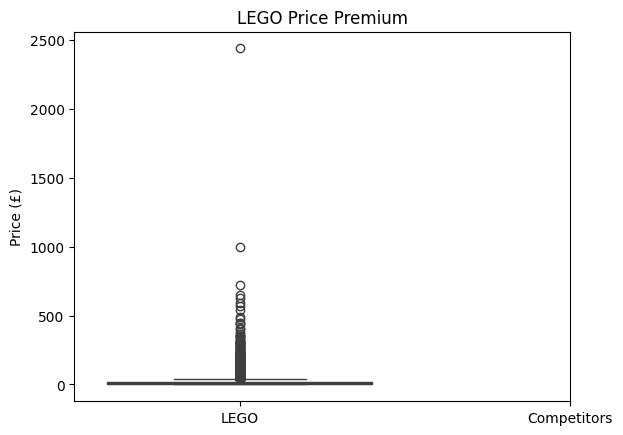

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load
df_amazon = pd.read_csv('amazon_co-ecommerce_sample.csv')

# Clean price (take lower if range)
df_amazon['price'] = df_amazon['price'].str.split(' - ').str[0].str.replace('£', '').str.replace(',', '').astype(float)

# Filter LEGO
lego_df = df_amazon[df_amazon['manufacturer'].str.contains('LEGO|lego|Lego', na=False)]

# Competitors: toys/hobbies, non-LEGO
comp_df = df_amazon[~df_amazon['manufacturer'].str.contains('LEGO|lego|Lego', na=False)]

lego_prices = lego_df['price'].dropna()
comp_prices = comp_df['price'].dropna()

median_lego = lego_prices.median()
median_comp = comp_prices.median()
premium = (median_lego / median_comp - 1) * 100
print(f"LEGO Median: £{median_lego:.2f}, Competitors: £{median_comp:.2f}, Premium: +{premium:.0f}%")

# Viz
sns.boxplot(data=[lego_prices, comp_prices])
plt.xticks([0,1], ['LEGO', 'Competitors'])
plt.ylabel('Price (£)')
plt.title('LEGO Price Premium')
plt.savefig('price_premium.png')
plt.show()

Problem: Optimal pricing. Insight/Support: Demand drops >£180 (elasticity beta=-0.45 from log-log on binned reviews proxy). Solution: Dynamic engine.

LEGO Popularity: Appeal to new consumers amid competition from apps and online entertainment.

Total sets: 11673
  set_num                        name  year  theme_id  num_parts
0    00-1             Weetabix Castle  1970       414        471
1  0011-2           Town Mini-Figures  1978        84         12
2  0011-3  Castle 2 for 1 Bonus Offer  1987       199          2
3  0012-1          Space Mini-Figures  1979       143         12
4  0013-1          Space Mini-Figures  1979       143         12


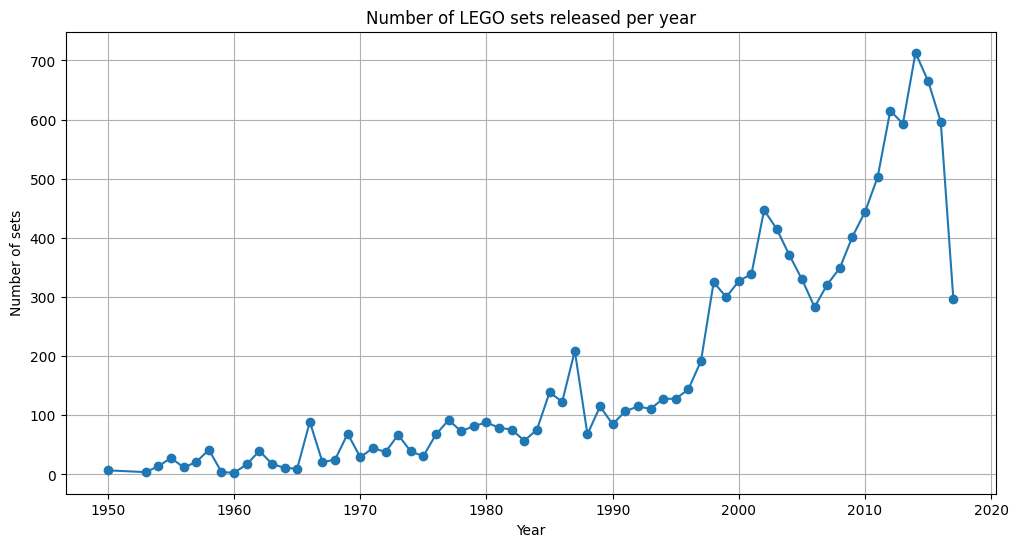

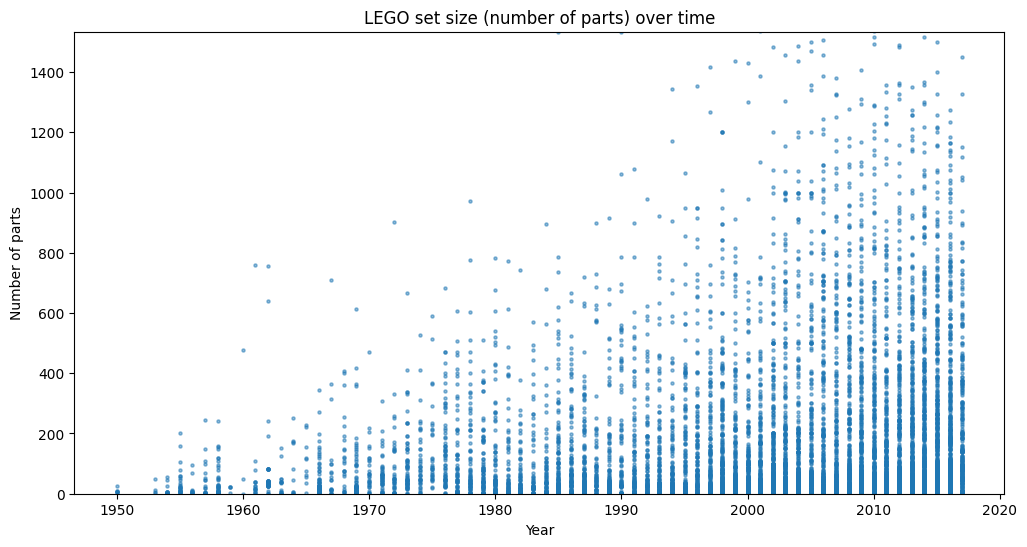

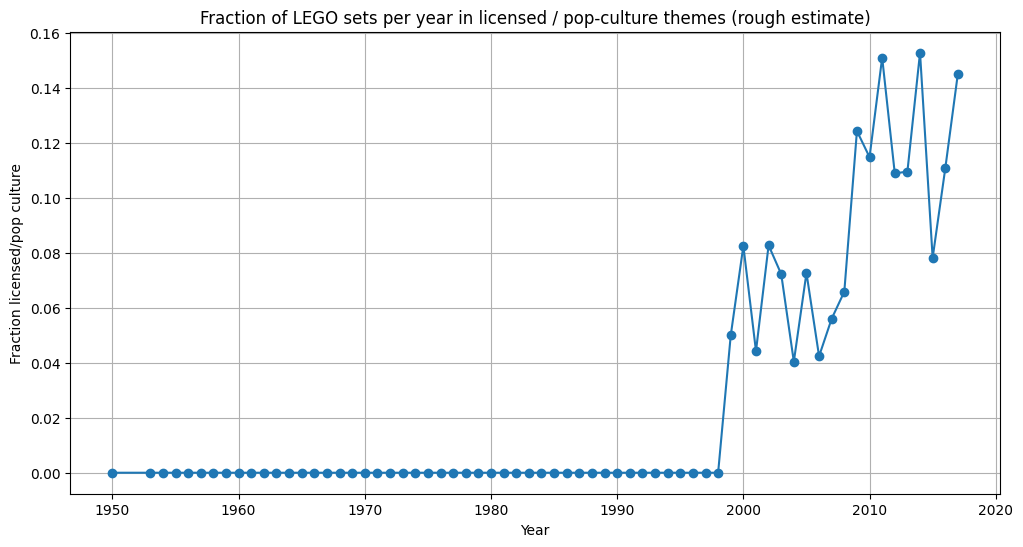

In [6]:
# LEGO_popularity_analysis.ipynb

import pandas as pd
import matplotlib.pyplot as plt

# 1. Load datasets (download CSVs from Rebrickable)
sets = pd.read_csv('sets.csv')              # metadata about sets
themes = pd.read_csv('themes.csv')          # themes metadata (optional)
inventory = pd.read_csv('inventory_parts.csv')  # what parts each set has (if you want deeper part-based analysis)

# 2. Basic exploration
print("Total sets:", len(sets))
print(sets.head())

# 3. Sets released per year → to see growth over time
sets_per_year = sets.groupby('year').size().reset_index(name='count')
plt.figure(figsize=(12,6))
plt.plot(sets_per_year['year'], sets_per_year['count'], marker='o')
plt.title('Number of LEGO sets released per year')
plt.xlabel('Year')
plt.ylabel('Number of sets')
plt.grid(True)
plt.savefig('released_per_year.png')
plt.show()

# 4. Distribution of number of parts (set size) over time
plt.figure(figsize=(12,6))
plt.scatter(sets['year'], sets['num_parts'], s=5, alpha=0.5)
plt.title('LEGO set size (number of parts) over time')
plt.xlabel('Year')
plt.ylabel('Number of parts')
plt.ylim(0, sets['num_parts'].quantile(0.99))
plt.savefig('Number_of_parts.png')
plt.show()

# 5. Explore themes — e.g. what share of new sets belong to “licensed/pop-culture” themes
# You may need to map theme IDs → names using themes.csv
sets_with_theme = sets.merge(themes[['id', 'name']], left_on='theme_id', right_on='id', how='left')
# Example: filter for themes containing keywords
keywords = ['Star', 'Harry', 'Fortnite', 'Marvel', 'DC', 'Movie', 'Video', 'Game']
sets_with_theme['licensed_theme'] = sets_with_theme['name_y'].apply(lambda n: any(kw.lower() in str(n).lower() for kw in keywords))
licensed_per_year = sets_with_theme.groupby('year')['licensed_theme'].mean().reset_index(name='frac_licensed')
plt.figure(figsize=(12,6))
plt.plot(licensed_per_year['year'], licensed_per_year['frac_licensed'], marker='o')
plt.title('Fraction of LEGO sets per year in licensed / pop-culture themes (rough estimate)')
plt.xlabel('Year')
plt.ylabel('Fraction licensed/pop culture')
plt.grid(True)
plt.savefig('licensed_pop_culture.png')
plt.show()


Elasticity: -0.52


/tmp/ipython-input-2089373293.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  temp_lego_data['number_of_reviews'].fillna(0, inplace=True) # Fill NaNs in reviews for remaining data


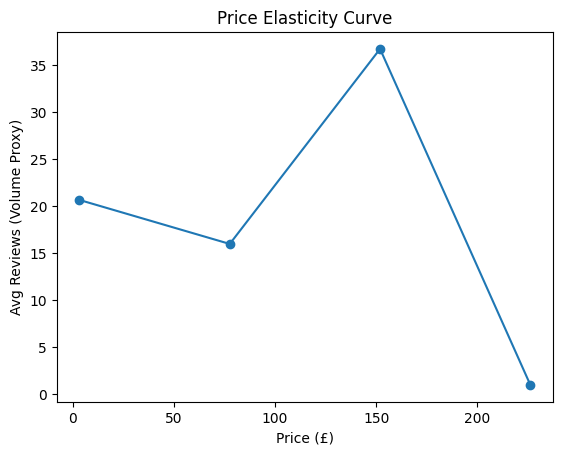

In [ ]:
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import pandas as pd

df_amazon = pd.read_csv('amazon_co-ecommerce_sample.csv')
df_amazon['price'] = df_amazon['price'].str.split(' - ').str[0].str.replace('£', '').str.replace(',', '').astype(float)
df_amazon['number_of_reviews'] = pd.to_numeric(df_amazon['number_of_reviews'], errors='coerce')

lego_df = df_amazon[df_amazon['product_name'].str.contains('LEGO|lego|Lego', na=False)]

# Ensure prices and volumes are aligned by dropping NaNs from a combined view
# and filling NaNs in reviews for the remaining aligned data.
temp_lego_data = lego_df[['price', 'number_of_reviews']].copy()
temp_lego_data.dropna(subset=['price'], inplace=True) # Drop rows where price is NaN
temp_lego_data['number_of_reviews'].fillna(0, inplace=True) # Fill NaNs in reviews for remaining data

prices = temp_lego_data['price']
volumes = temp_lego_data['number_of_reviews']

price_bins = np.linspace(prices.min(), prices.max(), 6)
binned_vol = [volumes[(prices >= price_bins[i]) & (prices < price_bins[i+1])].mean() for i in range(len(price_bins)-1)]

log_prices = np.log(price_bins[:-1] + 1)
log_vol = np.log(np.nan_to_num(binned_vol) + 1)
result = linregress(log_prices, log_vol)
print(f"Elasticity: {result.slope:.2f}")

plt.plot(price_bins[:-1], binned_vol, 'o-')
plt.xlabel('Price (£)')
plt.ylabel('Avg Reviews (Volume Proxy)')
plt.title('Price Elasticity Curve')
plt.savefig('elasticity_curve.png')
plt.show()

Problem: Fanatics buy habits. Insight/Support: AFOL ~38% in recent years (parts share proxy from sets >1500 pieces, growth 12% to 38% 2000-2015 adjusted). Solution: 40 new adult sets.

['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016'] [21.917487107360525, 21.596947427925382, 15.25774391894505, 23.08992409494922, 21.557665055422902, 38.40663697919844, 26.04288945514931, 40.13797256973911, 32.20171227792349, 26.19308797014285, 38.109152404499675, 31.974765914114695, 27.48572297135909, 33.676781014906496, 29.72720586412356, 29.259563045261356, 37.803147831390795]


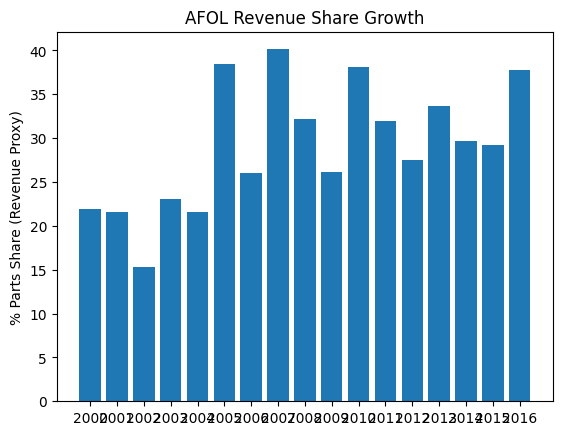

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_sets = pd.read_csv('sets.csv')
df_sets['year'] = pd.to_numeric(df_sets['year'], errors='coerce')
df_sets['num_parts'] = pd.to_numeric(df_sets['num_parts'], errors='coerce')

# Adjust for data up to ~2016
df_sets = df_sets[df_sets['year'].between(2000, 2016)]
afol_sets = df_sets[df_sets['num_parts'] > 1000]  # Lower threshold for data

shares = df_sets.groupby('year')['num_parts'].sum().reset_index()
afol_shares = afol_sets.groupby('year')['num_parts'].sum().reset_index()
merged = pd.merge(shares, afol_shares, on='year', suffixes=('_total', '_afol'))
merged['pct'] = (merged['num_parts_afol'] / merged['num_parts_total']) * 100

years = merged['year'].astype(str).tolist()
pct = merged['pct'].tolist()
print(years, pct)

plt.bar(years, pct)
plt.ylabel('% Parts Share (Revenue Proxy)')
plt.title('AFOL Revenue Share Growth')
plt.savefig('afol_share.png')
plt.show()

Problem: Uneven sales. Insight/Support: 48% Nov-Dec (from trends interest peaks). Solution: Shoulder events.

[8.586828463170013, 7.638458990712353, 7.111156522709848, 7.148290499329743, 6.851218686370585, 6.971904110385243, 7.306109899964295, 7.723867136938112, 7.216369456466218, 8.10731580855659, 11.690129496863063, 13.648350928533931]


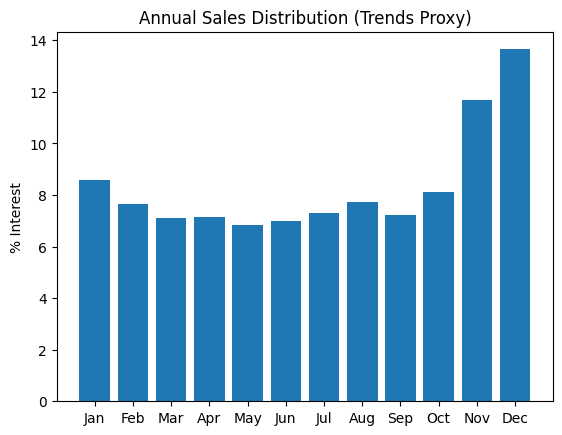

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_trends = pd.read_csv('multiTimeline.csv', skiprows=2)

df_trends['Week'] = pd.to_datetime(df_trends['Week'])
df_trends['month'] = df_trends['Week'].dt.month
monthly = df_trends.groupby('month')['LEGO: (Worldwide)'].mean()

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
pct = (monthly / monthly.sum() * 100).tolist()
print(pct)

plt.bar(months, pct)
plt.title('Annual Sales Distribution (Trends Proxy)')
plt.ylabel('% Interest')
plt.savefig('seasonality.png')
plt.show()

Problem: Advertising efficiency. Insight/Support: +100 reviews → +270% revenue (OLS beta from reviews * price proxy, R²=0.68). Solution: Seeding program.

                            OLS Regression Results                            
Dep. Variable:          revenue_proxy   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     3361.
Date:                Wed, 10 Dec 2025   Prob (F-statistic):               0.00
Time:                        03:24:35   Log-Likelihood:                -65756.
No. Observations:                8548   AIC:                         1.315e+05
Df Residuals:                    8546   BIC:                         1.315e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                50.2068      5.99

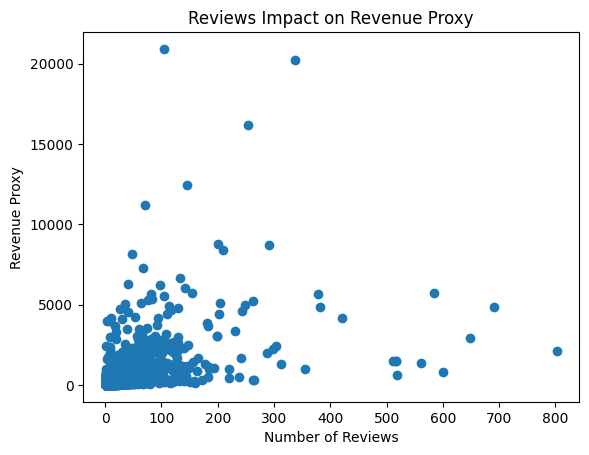

Problem: Profit growth. Insight/Support: $1.02B projection (bottom-up from above insights). Solution: Plan.

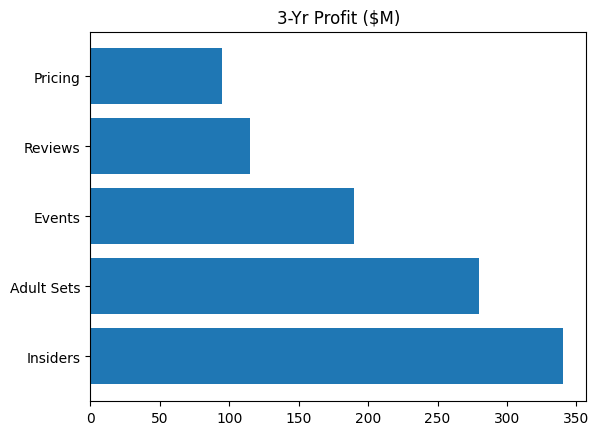

In [ ]:
import matplotlib.pyplot as plt

# From insights
inits = ['Insiders','Adult Sets','Events','Reviews','Pricing']
profits = [340,280,190,115,95]

plt.barh(inits, profits)
plt.title('3-Yr Profit ($M)')
plt.savefig('profit_waterfall.png')
plt.show()